In [2]:
import numpy as np
import random
import sklearn.linear_model as linear
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as selection
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics

import torch as th
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
databasePath = "../eICU/training/"
exportPath = "../eICU/training/"

In [19]:
finalFeatures = pd.read_csv(databasePath + '/finalFeatures.csv')
finalFeatures = finalFeatures.fillna(0) # fills nan from kurtosis and skew
finalFeatures

,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
0,1412030,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,68.0,120.0,...,-1.4140,0.6875,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
1,1412271,37.6965,38.1204,38.0819,0.1278,11.0000,-3.3166,38.1204,103.0,112.0,...,0.2131,1.4000,2.4331,2.4331,2.4331,0.0000,0.0000,0.0000,2.4331,1.0
2,1412290,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,57.0,75.0,...,0.1274,1.2345,4.4543,4.4543,4.4543,0.0000,0.0000,0.0000,4.4543,0.0
3,1412660,37.4000,38.0000,37.7832,0.1822,-0.3726,-0.6013,37.8000,84.0,109.0,...,-0.5963,1.6136,0.8306,3.7375,3.6347,0.4814,21.5211,-4.7383,3.7375,0.0
4,1412840,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,70.0,106.0,...,-0.0575,1.0584,0.6420,1.7976,1.5475,0.2748,2.0620,-1.6282,1.5956,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199338,33532516,32.2000,37.7000,35.3112,2.1057,-1.7574,-0.2178,36.6000,51.0,104.0,...,-0.0645,2.6469,0.0980,5.6373,1.0889,0.9895,3.4195,1.6831,0.8171,1.0
199339,33532517,32.2000,37.4000,34.5467,1.8862,-1.7703,0.2656,33.4000,51.0,104.0,...,0.1481,2.5493,0.0980,5.6373,0.9832,1.0570,3.9619,1.9491,0.6334,1.0
199340,33532518,32.2000,36.8000,34.1643,1.7398,-1.4068,0.6213,33.1000,60.0,104.0,...,0.0064,2.4888,0.0980,5.6373,1.0385,1.1231,2.9569,1.7434,0.6010,1.0
199341,33532540,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,72.0,83.0,...,-2.1039,2.2769,0.3576,19.0703,3.7475,2.6719,13.1009,3.2470,2.3838,0.0


#### Balancind Data by Random Under-Sampling

In [22]:
sepsis = finalFeatures[finalFeatures['diagnosis'] == 1]
notSepsis = finalFeatures[finalFeatures['diagnosis'] == 0]
print(f'Sepsis Size: {sepsis.shape[0]} Not Sepsis Size: {notSepsis.shape[0]}')

Sepsis Size: 77520 Not Sepsis Size: 121823


In [23]:
notSepsis = notSepsis.sample(n=sepsis.shape[0])
print(f'Sepsis Size: {sepsis.shape[0]} Not Sepsis Size: {notSepsis.shape[0]}')
notSepsis

Sepsis Size: 77520 Not Sepsis Size: 77520


,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
33410,6520780,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,27.0,71.0,...,0.0000,1.9000,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
95698,15989710,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,69.0,173.0,...,-0.4682,0.2870,3.6496,18.2482,9.5915,3.3221,-1.0363,0.1271,9.1241,0.0
16216,3927750,36.0280,37.7220,37.2031,0.3845,-1.3501,-0.2428,37.1670,70.0,181.0,...,10.5938,0.4087,0.0000,7.0968,1.0179,1.9722,1.8016,1.7944,0.0000,0.0
140844,27267290,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,0.0,117.0,...,1.7746,0.9100,0.6935,3.8141,2.2906,0.9430,-1.3591,-0.0713,2.2863,0.0
18408,4323350,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,57.0,76.0,...,-1.3540,0.4980,0.5869,3.7559,1.5410,0.6408,1.2950,0.8953,1.4671,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26046,5357950,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,88.0,132.0,...,1.3875,0.3999,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
21025,4683680,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,51.0,116.0,...,0.4853,1.8766,0.0267,13.3333,3.2324,3.5907,0.1684,1.0505,2.8729,0.0
12495,3241980,37.3330,38.0560,37.7222,0.1352,0.9506,-0.2358,37.7220,67.0,121.0,...,-0.5056,0.7650,0.0000,28.9855,2.5858,3.3348,25.9065,4.3360,2.7576,0.0
193848,32418630,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,57.0,113.0,...,-0.0766,1.2137,0.0000,0.7118,0.3691,0.1793,-0.8589,-0.0016,0.3674,0.0


In [24]:
finalFeaturesBalanced = pd.concat([notSepsis, sepsis])
finalFeaturesBalanced = finalFeaturesBalanced.sample(frac=1)  #shuffle data
finalFeaturesBalanced

,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
174302,30963785,20.9000,37.7000,35.5941,1.2355,96.5432,-8.5950,35.4000,54.0,136.0,...,-0.0433,4.9562,0.0000,5.2197,0.6972,0.9021,3.7687,1.8985,0.2417,1.0
159384,30032386,37.6965,38.1204,38.0599,0.1539,3.7917,-2.2948,38.1204,80.0,88.0,...,0.0000,1.2829,36.0206,36.0206,36.0206,0.0000,0.0000,0.0000,36.0206,1.0
103227,17270580,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,66.0,130.0,...,1.1572,0.9880,0.4505,37.9665,16.4859,13.7345,-1.5885,0.0700,16.4093,0.0
198301,33477607,37.6965,38.1204,38.0878,0.1176,13.0000,-3.6056,38.1204,100.0,111.0,...,1.8858,1.1279,2.8139,12.1827,4.8877,3.5364,1.2705,1.6635,3.0126,1.0
91148,15756951,37.6965,38.1204,38.1146,0.0493,69.4640,-8.4255,38.1204,89.0,123.0,...,0.6853,1.0208,1.5748,1.5748,1.5748,0.0000,0.0000,0.0000,1.5748,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112278,18253020,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,0.0,152.0,...,-0.5368,3.2448,4.9411,4.9411,4.9411,0.0000,0.0000,0.0000,4.9411,0.0
121655,21901250,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,61.0,129.0,...,0.2510,0.7765,1.6750,10.4690,2.6053,1.8730,1.5640,1.7019,1.6750,0.0
104787,17442563,37.6965,38.1204,38.1200,0.0138,936.3298,-30.6213,38.1204,60.0,149.0,...,3.3434,1.1089,0.5690,28.7612,15.8676,7.2003,-0.4431,-0.6141,16.5506,1.0
75466,11798661,37.6965,38.1204,38.0733,0.1413,9.0000,-3.0000,38.1204,91.0,103.0,...,3.0000,1.9800,24.3566,24.3566,24.3566,0.0000,0.0000,0.0000,24.3566,1.0


In [26]:
print('finalFeaturesBalanced diagnosis count:')
finalFeaturesBalanced.diagnosis.value_counts()

finalFeaturesBalanced diagnosis count:


0.0    77520
1.0    77520
Name: diagnosis, dtype: int64

#### Cleaning data and Sorting to Input and Target Arrays

In [27]:
x = [] # input (attributes)
y = [] # output (targets)

x = finalFeaturesBalanced.iloc[:, 1:57].values
y = finalFeaturesBalanced.iloc[:, 57].values


#### Setting up Models for Neural Network

In [28]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()

    def forward(self, x):
        return None

    def loss(self, x, y):
        probs = self.forward(x)
        return self.loss_func(probs, y)

    def predict_proba(self, x, as_numpy=False):
        res = self.forward(x)
        if as_numpy:
            res = res.cpu().detach().numpy()
        return res

    def predict(self, x, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(x, as_numpy)
        return probs > threshold

    def fit(self, x_train, x_test, y_train, y_test, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        train_loss_curve = []
        test_loss_curve = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            train_loss_val = self.loss(x_train, y_train) + self.regularize(lam)
            train_loss_curve.append(train_loss_val.data.item())
            train_loss_val.backward()
            optimizer.step()
            
            test_loss_val = self.loss(x_test, y_test) + self.regularize(lam)
            test_loss_curve.append(test_loss_val.data.item())
            
            if epoch % 500 == 0:
                print(f'Epoch {epoch}, Train Loss: {train_loss_val:.5f}, Test Loss: {test_loss_val:.5f}')
            
            
        return train_loss_curve, test_loss_curve

    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [29]:
class NNModel(Model):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(56, 113, bias=True)
        self.act1 = nn.PReLU()
        self.l2 = nn.Linear(113, 56, bias=True)
        self.act2 = nn.PReLU()
        self.l3 = nn.Linear(56, 1, bias=True)
        self.act3 = nn.Sigmoid()

    def get_intermediary(self, x):
        res = self.l1(x)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)

        return res

    def forward(self, X):
        res = self.get_intermediary(X)
        res = self.l3(res)
        res = self.act3(res)
        return res

#### Applying Logistic Regression and Neural Network Model

In [30]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
def random_guessing(inputs):
    prediction = []
    
    for values in inputs:
        prediction.append(random.randint(0, 1))
        
    return prediction

In [32]:
kf = selection.KFold(n_splits=2, shuffle=True)
kf.get_n_splits(x)

f1_lr = []
f1_nn = []
f1_rf = []
f1_gnb = []
f1_rand = []

precision_lr = []
precision_nn = []
precision_rf = []
precision_gnb = []
precision_rand = []

accuracy_lr = []
accuracy_nn = []
accuracy_rf = []
accuracy_gnb = []
accuracy_rand = []

recall_lr = []
recall_nn = []
recall_rf = []
recall_gnb = []
recall_rand = []

ras_lr = []
ras_nn = []
ras_rf = []
ras_gnb = []
ras_rand = []

train_curve = []
test_curve = []

def random_guessing(inputs):
    prediction = []
    
    for values in inputs:
        prediction.append(random.randint(0, 1))
        
    return prediction

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    f1_lr.append(metrics.f1_score(y_test, predictions))
    precision_lr.append(metrics.precision_score(y_test, predictions))
    accuracy_lr.append(metrics.accuracy_score(y_test, predictions))
    recall_lr.append(metrics.recall_score(y_test, predictions))
    ras_lr.append(metrics.roc_auc_score(y_test, predictions))
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    probs = rf.predict_proba(X_test)[:,1]
    f1_rf.append(metrics.f1_score(y_test, predictions))
    precision_rf.append(metrics.precision_score(y_test, predictions))
    accuracy_rf.append(metrics.accuracy_score(y_test, predictions))
    recall_rf.append(metrics.recall_score(y_test, predictions))
    ras_rf.append(metrics.roc_auc_score(y_test, predictions))
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictions = gnb.predict(X_test)
    probs = gnb.predict_proba(X_test)[:,1]
    f1_gnb.append(metrics.f1_score(y_test, predictions))
    precision_gnb.append(metrics.precision_score(y_test, predictions))
    accuracy_gnb.append(metrics.accuracy_score(y_test, predictions))
    recall_gnb.append(metrics.recall_score(y_test, predictions))
    ras_gnb.append(metrics.roc_auc_score(y_test, predictions))
    
    predictions = random_guessing(X_test)
    f1_rand.append(metrics.f1_score(y_test, predictions))
    precision_rand.append(metrics.precision_score(y_test, predictions))
    accuracy_rand.append(metrics.accuracy_score(y_test, predictions))
    recall_rand.append(metrics.recall_score(y_test, predictions))
    ras_rand.append(metrics.roc_auc_score(y_test, predictions))
    
    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    nn1 = NNModel()
    nn1.to(device)

    train_loss, test_loss = nn1.fit(X_train, X_test, y_train, y_test, epochs=4000, lr=0.0002, lam=0.0001)
    
    train_curve.append(train_loss)
    test_curve.append(test_loss)
    
    predictions = nn1.predict(X_test, as_numpy=True)
    probs = nn1.predict_proba(X_test, as_numpy=True)
    
    f1_nn.append(metrics.f1_score(y_test.cpu(), predictions))
    precision_nn.append(metrics.precision_score(y_test.cpu(), predictions))
    accuracy_nn.append(metrics.accuracy_score(y_test.cpu(), predictions))
    recall_nn.append(metrics.recall_score(y_test.cpu(), predictions))
    ras_nn.append(metrics.roc_auc_score(y_test.cpu(), predictions))

Epoch 0, Train Loss: 0.69703, Test Loss: 0.69503
Epoch 500, Train Loss: 0.34896, Test Loss: 0.35229
Epoch 1000, Train Loss: 0.24240, Test Loss: 0.24985
Epoch 1500, Train Loss: 0.19646, Test Loss: 0.20690
Epoch 2000, Train Loss: 0.17016, Test Loss: 0.18321
Epoch 2500, Train Loss: 0.15218, Test Loss: 0.16439
Epoch 3000, Train Loss: 0.13800, Test Loss: 0.14915
Epoch 3500, Train Loss: 0.12889, Test Loss: 0.14007
Epoch 0, Train Loss: 0.69599, Test Loss: 0.69419
Epoch 500, Train Loss: 0.35761, Test Loss: 0.35299
Epoch 1000, Train Loss: 0.25862, Test Loss: 0.24858
Epoch 1500, Train Loss: 0.21778, Test Loss: 0.20483
Epoch 2000, Train Loss: 0.19945, Test Loss: 0.18318
Epoch 2500, Train Loss: 0.18503, Test Loss: 0.16790
Epoch 3000, Train Loss: 0.17106, Test Loss: 0.15538
Epoch 3500, Train Loss: 0.15521, Test Loss: 0.14336


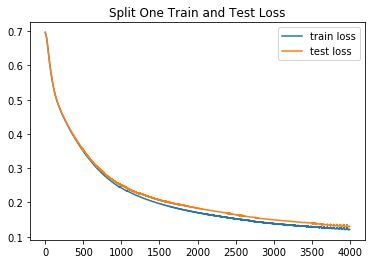

In [33]:
plt.plot(train_curve[0], label='train loss')
plt.plot(test_curve[0], label='test loss')
plt.legend()
plt.title('Split One Train and Test Loss')
plt.show()

In [34]:
def plot_loss(loss_curve, i):
    plt.plot(list(range(len(loss_curve))), loss_curve, label=f'Split {i+1}')

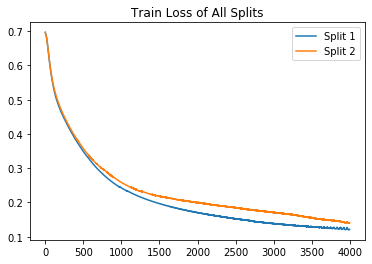

In [35]:
for i, curve in enumerate(train_curve):
    plot_loss(curve, i)

plt.legend()
plt.title('Train Loss of All Splits')
plt.show()

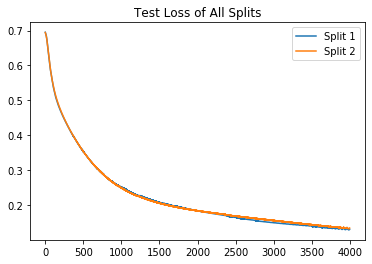

In [36]:
for i, curve in enumerate(test_curve):
    plot_loss(curve, i)

plt.legend()
plt.title('Test Loss of All Splits')
plt.show()

#### Comparing Statistical Results for the Models

In [37]:
print("Random Guessing Model F1 Score Mean: ", np.mean(f1_rand))
print("Random Guessing Model F1 Score Standard Deviation: ", np.std(f1_rand), '\n')

print("Random Guessing Model Precision Score Mean: ", np.mean(precision_rand))
print("Random Guessing Model Precision Score Standard Deviation: ", np.std(precision_rand), '\n')

print("Random Guessing Model Accuracy Score Mean: ", np.mean(accuracy_rand))
print("Random Guessing Model Accuracy Score Standard Deviation: ", np.std(accuracy_rand), '\n')

print("Random Guessing Model Recall Score Mean: ", np.mean(recall_rand))
print("Random Guessing Model Recall Score Standard Deviation: ", np.std(recall_rand), '\n')

print("Random Guessing Model ROC AUC Score Mean: ", np.mean(ras_rand))
print("Random Guessing Model ROC AUC Score Standard Deviation: ", np.std(ras_rand))

Random Guessing Model F1 Score Mean:  0.5016068577802214
Random Guessing Model F1 Score Standard Deviation:  0.0011734645049326087 

Random Guessing Model Precision Score Mean:  0.502369977165931
Random Guessing Model Precision Score Standard Deviation:  0.0004638414696762627 

Random Guessing Model Accuracy Score Mean:  0.5023606811145511
Random Guessing Model Accuracy Score Standard Deviation:  0.0004901960784313708 

Random Guessing Model Recall Score Mean:  0.5008566683448419
Random Guessing Model Recall Score Standard Deviation:  0.002800891042032349 

Random Guessing Model ROC AUC Score Mean:  0.502365038393028
Random Guessing Model ROC AUC Score Standard Deviation:  0.0004873552370093237


In [38]:
print("Logistic Regression Model F1 Score Mean: ", np.mean(f1_lr))
print("Logistic Regression Model F1 Score Standard Deviation: ", np.std(f1_lr), '\n')

print("Logistic Regression Model Precision Score Mean: ", np.mean(precision_lr))
print("Logistic Regression Model Precision Score Standard Deviation: ", np.std(precision_lr), '\n')

print("Logistic Regression Model Accuracy Score Mean: ", np.mean(accuracy_lr))
print("Logistic Regression Model Accuracy Score Standard Deviation: ", np.std(accuracy_lr), '\n')

print("Logistic Regression Model Recall Score Mean: ", np.mean(recall_lr))
print("Logistic Regression Model Recall Score Standard Deviation: ", np.std(recall_lr), '\n')

print("Logistic Regression Model ROC AUC Score Mean: ", np.mean(ras_lr))
print("Logistic Regression Model ROC AUC Score Standard Deviation: ", np.std(ras_lr))

Logistic Regression Model F1 Score Mean:  0.9422714300240997
Logistic Regression Model F1 Score Standard Deviation:  0.0009612801945407812 

Logistic Regression Model Precision Score Mean:  0.9656131449712533
Logistic Regression Model Precision Score Standard Deviation:  0.0009838756240850288 

Logistic Regression Model Accuracy Score Mean:  0.9436339009287926
Logistic Regression Model Accuracy Score Standard Deviation:  0.0009352425180598201 

Logistic Regression Model Recall Score Mean:  0.9200386739878531
Logistic Regression Model Recall Score Standard Deviation:  0.002726079029956474 

Logistic Regression Model ROC AUC Score Mean:  0.9436373574711023
Logistic Regression Model ROC AUC Score Standard Deviation:  0.0008907971131508208


In [39]:
print("Random Forest Model F1 Score Mean: ", np.mean(f1_rf))
print("Random Forest Model F1 Score Standard Deviation: ", np.std(f1_rf), '\n')

print("Random Forest Model Precision Score Mean: ", np.mean(precision_rf))
print("Random Forest Model Precision Score Standard Deviation: ", np.std(precision_rf), '\n')

print("Random Forest Model Accuracy Score Mean: ", np.mean(accuracy_rf))
print("Random Forest Model Accuracy Score Standard Deviation: ", np.std(accuracy_rf), '\n')

print("Random Forest Model Recall Score Mean: ", np.mean(recall_rf))
print("Random Forest Model Recall Score Standard Deviation: ", np.std(recall_rf), '\n')

print("Random Forest Model ROC AUC Score Mean: ", np.mean(ras_rf))
print("Random Forest Model ROC AUC Score Standard Deviation: ", np.std(ras_rf), '\n')

Random Forest Model F1 Score Mean:  0.9946220607824525
Random Forest Model F1 Score Standard Deviation:  0.0002652420455480642 

Random Forest Model Precision Score Mean:  0.9895796908956391
Random Forest Model Precision Score Standard Deviation:  0.0005498744991782045 

Random Forest Model Accuracy Score Mean:  0.9945949432404542
Random Forest Model Accuracy Score Standard Deviation:  0.00025799793601649634 

Random Forest Model Recall Score Mean:  0.9997162498548232
Random Forest Model Recall Score Standard Deviation:  2.52653828535232e-05 

Random Forest Model ROC AUC Score Mean:  0.9945954585701633
Random Forest Model ROC AUC Score Standard Deviation:  0.0002483535148663507 



In [40]:
print("Gaussian Naive Bayes Model F1 Score Mean: ", np.mean(f1_gnb))
print("Gaussian Naive Bayes Model F1 Score Standard Deviation: ", np.std(f1_gnb), '\n')

print("Gaussian Naive Bayes Model Precision Score Mean: ", np.mean(precision_gnb))
print("Gaussian Naive Bayes Model Precision Score Standard Deviation: ", np.std(precision_gnb), '\n')

print("Gaussian Naive Bayes Model Accuracy Score Mean: ", np.mean(accuracy_gnb))
print("Gaussian Naive Bayes Model Accuracy Score Standard Deviation: ", np.std(accuracy_gnb), '\n')

print("Gaussian Naive Bayes Model Recall Score Mean: ", np.mean(recall_gnb))
print("Gaussian Naive Bayes Model Recall Score Standard Deviation: ", np.std(recall_gnb), '\n')

print("Gaussian Naive Bayes Model ROC AUC Score Mean: ", np.mean(ras_gnb))
print("Gaussian Naive Bayes Model ROC AUC Score Standard Deviation: ", np.std(ras_gnb), '\n')

Gaussian Naive Bayes Model F1 Score Mean:  0.8843412425461574
Gaussian Naive Bayes Model F1 Score Standard Deviation:  0.01670062096594299 

Gaussian Naive Bayes Model Precision Score Mean:  0.9017463152690943
Gaussian Naive Bayes Model Precision Score Standard Deviation:  0.019716915111241018 

Gaussian Naive Bayes Model Accuracy Score Mean:  0.8869259545923633
Gaussian Naive Bayes Model Accuracy Score Standard Deviation:  0.01174535603715171 

Gaussian Naive Bayes Model Recall Score Mean:  0.8703253000281187
Gaussian Naive Bayes Model Recall Score Standard Deviation:  0.05056672479612867 

Gaussian Naive Bayes Model ROC AUC Score Mean:  0.8868528976370501
Gaussian Naive Bayes Model ROC AUC Score Standard Deviation:  0.011776483865465703 



In [41]:
print("Neural Network Model F1 Score Mean: ", np.mean(f1_nn))
print("Neural Network Model F1 Score Standard Deviation: ", np.std(f1_nn), '\n')

print("Neural Network Model Precision Score Mean: ", np.mean(precision_nn))
print("Neural Network Model Precision Score Standard Deviation: ", np.std(precision_nn), '\n')

print("Neural Network Model Accuracy Score Mean: ", np.mean(accuracy_nn))
print("Neural Network Model Accuracy Score Standard Deviation: ", np.std(accuracy_nn), '\n')

print("Neural Network Model Recall Score Mean: ", np.mean(recall_nn))
print("Neural Network Model Recall Score Standard Deviation: ", np.std(ras_nn), '\n')

print("Neural Network Model ROC AUC Score Mean: ", np.mean(ras_nn))
print("Neural Network Model ROC AUC Score Standard Deviation: ", np.std(ras_nn), '\n')

Neural Network Model F1 Score Mean:  0.9564081344931845
Neural Network Model F1 Score Standard Deviation:  0.002852885330292876 

Neural Network Model Precision Score Mean:  0.9632232965083886
Neural Network Model Precision Score Standard Deviation:  0.009634535333420513 

Neural Network Model Accuracy Score Mean:  0.9567337461300309
Neural Network Model Accuracy Score Standard Deviation:  0.0023606811145510664 

Neural Network Model Recall Score Mean:  0.9500024485595304
Neural Network Model Recall Score Standard Deviation:  0.0023479586161403443 

Neural Network Model ROC AUC Score Mean:  0.9567575723732823
Neural Network Model ROC AUC Score Standard Deviation:  0.0023479586161403443 



In [42]:
resultdf = pd.DataFrame(columns=['Classifiers', 'F1 Score', 'Accuracy Score', 'Precision Score', 'Recall Score', 'ROC AUC Score'])

resultdf.loc[0] = 'Random Guessing', np.mean(f1_rand), np.mean(accuracy_rand), np.mean(precision_rand), np.mean(recall_rand),  np.mean(ras_rand)
resultdf.loc[1] = 'Logistic Regression', np.mean(f1_lr), np.mean(accuracy_lr), np.mean(precision_lr), np.mean(recall_lr),  np.mean(ras_lr)
resultdf.loc[2] = 'Neural Network', np.mean(f1_nn), np.mean(accuracy_nn), np.mean(precision_nn), np.mean(recall_nn),  np.mean(ras_nn)
resultdf.loc[3] = 'Random Forest', np.mean(f1_rf), np.mean(accuracy_rf), np.mean(precision_rf), np.mean(recall_rf),  np.mean(ras_rf)
resultdf.loc[4] = 'Gaussian Naive Bayes ', np.mean(f1_gnb), np.mean(accuracy_gnb), np.mean(precision_gnb), np.mean(recall_gnb),  np.mean(ras_gnb)

resultdf

,Classifiers,F1 Score,Accuracy Score,Precision Score,Recall Score,ROC AUC Score
0,Random Guessing,0.501607,0.502361,0.502370,0.500857,0.502365
1,Logistic Regression,0.942271,0.943634,0.965613,0.920039,0.943637
2,Neural Network,0.956408,0.956734,0.963223,0.950002,0.956758
3,Random Forest,0.994622,0.994595,0.989580,0.999716,0.994595
4,Gaussian Naive Bayes,0.884341,0.886926,0.901746,0.870325,0.886853


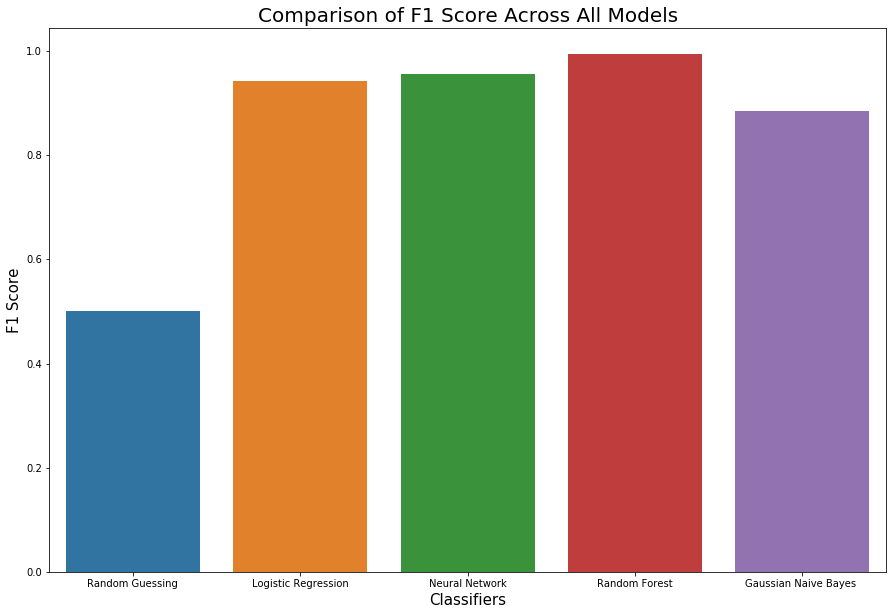

In [43]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='F1 Score')
plt.title('Comparison of F1 Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("F1 Score", fontsize=15)
plt.show()

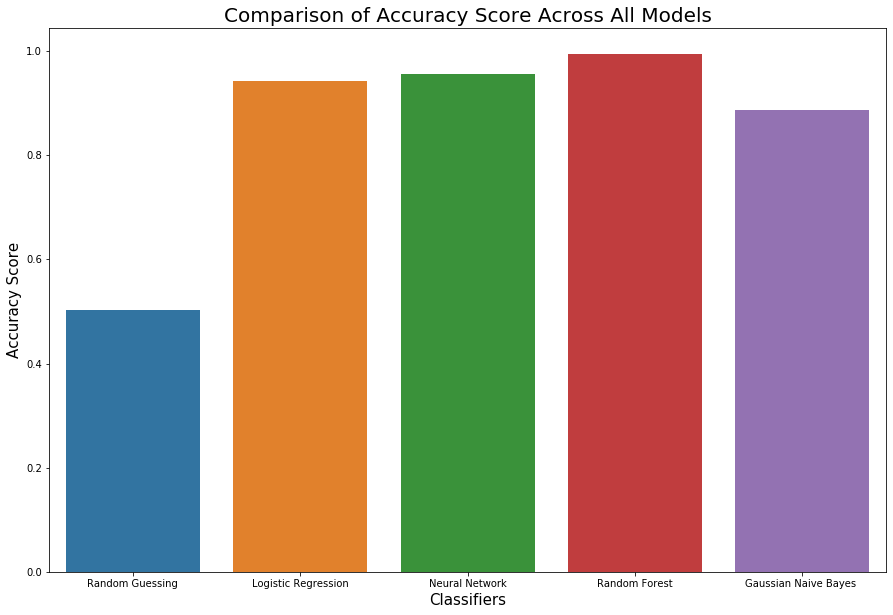

In [44]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Accuracy Score')
plt.title('Comparison of Accuracy Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.show()

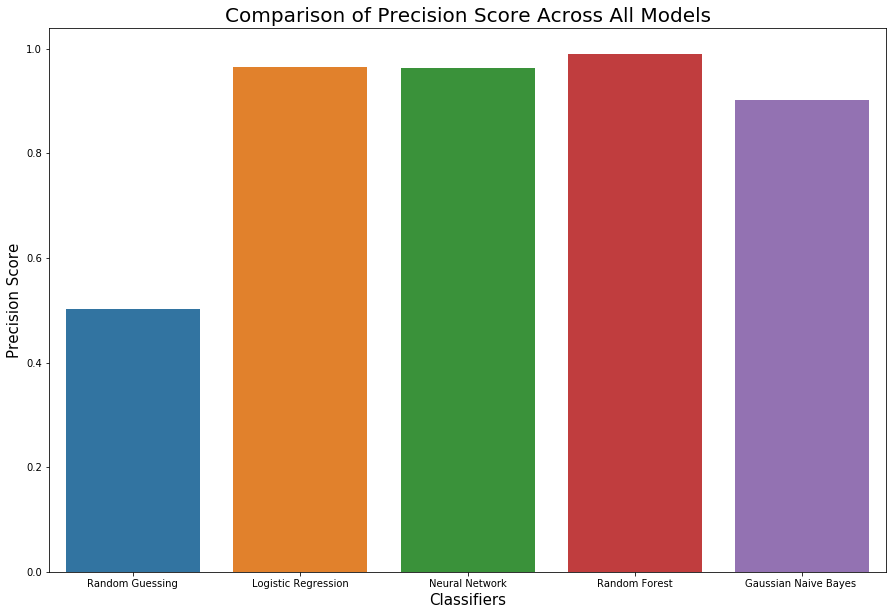

In [45]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Precision Score')
plt.title('Comparison of Precision Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Precision Score", fontsize=15)
plt.show()

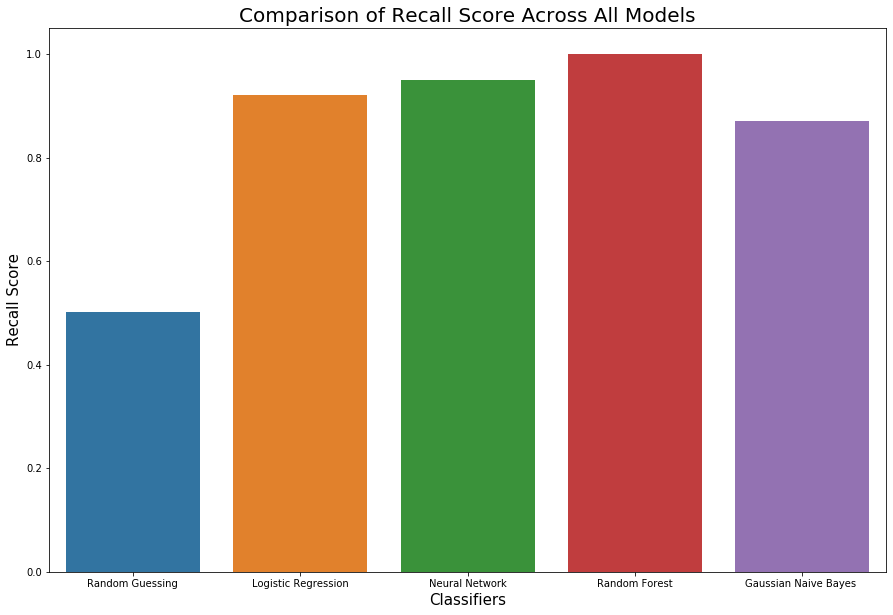

In [46]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Recall Score')
plt.title('Comparison of Recall Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Recall Score", fontsize=15)
plt.show()

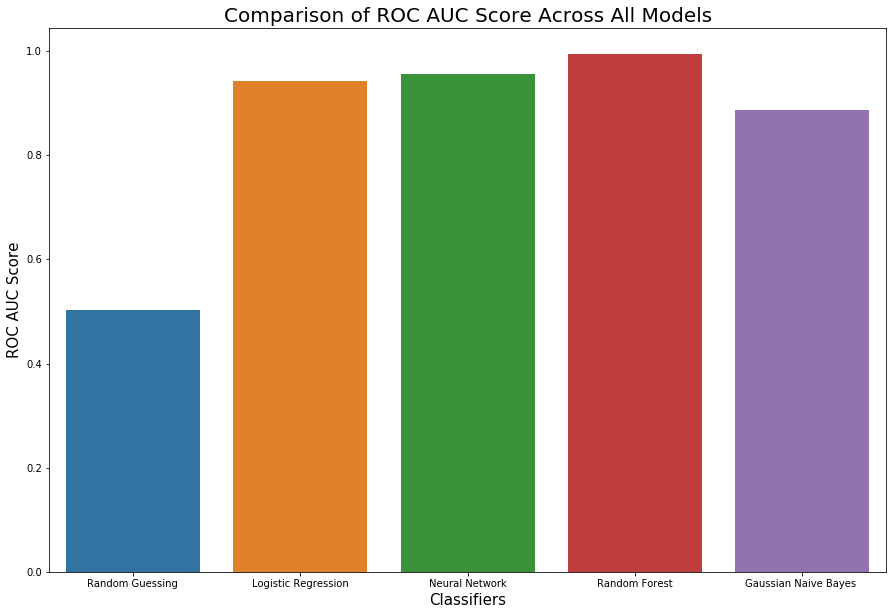

In [47]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='ROC AUC Score')
plt.title('Comparison of ROC AUC Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("ROC AUC Score", fontsize=15)
plt.show()

#### Intermediary Workings of the Neural Network

In [ ]:
X_transformed = th.tensor(x, dtype=th.float32)
representations = nn1.get_intermediary(X_transformed)
representations = representations.detach().numpy()

In [ ]:
colors = np.array(['tab:red' if cl == 0 else 'tab:blue' for cl in y])
plt.scatter(representations[:,0], representations[:,1], c=colors)